In [10]:
import csv
import re
from statistics import median
from matplotlib import pyplot as plt

In [11]:
nick = "PeX"

In [15]:
# dict "[Map] = [points, set of fin-ed players, list of all times]"
read_data = {}

# "Fun" server maps should be excluded
# Also some maps were deleted but still exist in race file, these maps will have points -1
maps_to_del = set()

with open('../ddnet-stats/maps.csv', 'r', encoding='latin-1') as fp:
    reader = csv.reader(fp, delimiter=',')
    next(reader)
    for row in reader:
        read_data[row[0]] = [int(row[2]), set(), []]
        if row[1] == "Fun":
            maps_to_del.add(row[0])


maps_finished_by_selected_nickname = dict()
with open('../ddnet-stats/race.csv', 'r', encoding='latin-1') as fp:
    reader = csv.reader(fp, delimiter=',')
    next(reader)
    for row in reader:
        if row[0] not in read_data.keys():
            maps_to_del.add(row[0])
            read_data[row[0]] = [-1, set(), []]
len(read_data)

2034

In [16]:
with open('../ddnet-stats/race.csv', 'r', encoding='latin-1') as f:
    next(f)  # skipping header
    for line in f:
        map_name = re.split(',".*",', line)[0][1:-1]
        other_info = (re.findall(',".*",', line))[0].split(',')
        time = float(other_info[-3])
        read_nick = ''.join(other_info[1:-3])[1:-1]
        read_data[map_name][1].add(read_nick)
        read_data[map_name][2].append(time)
        if nick == read_nick:
            if map_name not in maps_finished_by_selected_nickname.keys():
                maps_finished_by_selected_nickname[map_name] = round(time / 60, 2)
            elif round(time / 60, 2) < maps_finished_by_selected_nickname[map_name]:
                maps_finished_by_selected_nickname[map_name] = round(time / 60, 2)

len(maps_finished_by_selected_nickname)

1220

In [17]:
for m_del in maps_to_del:
    del read_data[m_del]
    if m_del in maps_finished_by_selected_nickname.keys():
        print(m_del)
        del maps_finished_by_selected_nickname[m_del]
len(read_data), len(maps_to_del)

TeeTacToe
Time Calculator


(2018, 16)

In [18]:
for map_key in read_data.keys():
    read_data[map_key][1] = len(read_data[map_key][1])
    read_data[map_key][2] = round(median(read_data[map_key][2]) / 60, 2)

In [19]:
unfinished_maps = read_data.copy()
for map_key in read_data.copy():
    if map_key not in maps_finished_by_selected_nickname.keys():
        del read_data[map_key]
for map_key in unfinished_maps.copy():
    if map_key in read_data.keys():
        del unfinished_maps[map_key]

In [20]:
# read_data - finished maps
# now read_data[map] = [pts, finished unique tees, median time for the map]
# unfinished_maps has the same structure as read_data
read_data = sorted(read_data.items(), key=lambda x: x[1][1])
unfinished_maps = sorted(unfinished_maps.items(), key=lambda x: x[1][1], reverse=True)
print('Count of finished maps:', len(maps_finished_by_selected_nickname))
print('Count of unfinished maps:', len(unfinished_maps))

Count of finished maps: 1218
Count of unfinished maps: 800


In [21]:
# for item in read_data:
#     print(item[0], ': ', item[1][0], 'pts, ', item[1][1], 'tees, ', item[1][2], 'mins median time,',
#           maps_finished_by_selected_nickname[item[0]], 'mins', nick, 'time')
# for item in unfinished_maps:
#     print(item[0], ': ', item[1][0], 'pts, ', item[1][1], 'tees, ', item[1][2], 'mins median time')

with open('output/finished_maps.csv', 'w', encoding='utf-8') as f:
    f.write('No.,Map,Points,CountOfFinishedTees,MedianTime(min),' + nick + '_time(min)\n')
    for no, item in enumerate(read_data, 1):
        f.write('{},{},{},{},{},{}\n'.format(no, item[0], item[1][0], item[1][1], item[1][2],
                                             maps_finished_by_selected_nickname[item[0]]))
with open('output/unfinished_maps.csv', 'w', encoding='utf-8') as f:
    f.write('No.,Map,Points,CountOfUnfinishedTees,MedianTime(min)\n')
    for no, item in enumerate(unfinished_maps, 1):
        f.write('{},{},{},{},{}\n'.format(no, item[0], item[1][0], item[1][1], item[1][2]))

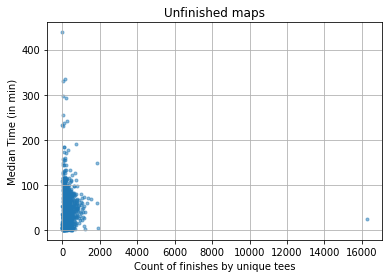

In [22]:
finishes = [item[1][1] for item in unfinished_maps]
med_time = [item[1][2] for item in unfinished_maps]
map_names = [item[0] for item in unfinished_maps]

# Plot
fig, ax = plt.subplots()
sc = plt.scatter(finishes, med_time, alpha=0.5, marker='.')

plt.title('Unfinished maps')
plt.xlabel('Count of finishes by unique tees')
plt.ylabel('Median Time (in min)')

annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    annot.set_text(", ".join([map_names[n] for n in ind["ind"]]))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


fig.canvas.mpl_connect("motion_notify_event", hover)
plt.grid()
plt.show()
